In [1]:
! pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=573aa52379379f15b60def1503efad9c768691422b979d93eb9cc6745516a053
  Stored in directory: /root/.cache/pip/wheels/b6/86/d5/cf62a3571b005f91cd9accefc5e10f40214538be997198afad
Successfully built ptflops


In [2]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchsummary import summary
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define how we want images transformed
resize = (28, 28)
trans = transforms.Compose([transforms.Resize(resize),
                            transforms.ToTensor()])

# Create training and validation sets
training_set = torchvision.datasets.FashionMNIST('./data', train=True, 
                                                 transform=trans, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, 
                                                   transform=trans, download=True)

# Create dataloaders for each set
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, 
                                              shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, 
                                                shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print("Training set size:", len(training_set))
print("Validation set size:", len(validation_set))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set size: 60000
Validation set size: 10000


# 1) MaxNet w/ ReLU

In [4]:
MaxLeNet = nn.Sequential(

    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),     #LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.MaxPool2d(2),                                          #nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),               #LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
    nn.MaxPool2d(2),                                          #nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(400, 120), nn.ReLU(),                           #LazyLinear(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.ReLU(),                            #LazyLinear(84), nn.Sigmoid(),
    nn.Linear(84, 10)                                         #LazyLinear(num_classes))
)

In [5]:
summary(MaxLeNet, input_size = (1, 28, 28), batch_size = 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             156
              ReLU-2            [32, 6, 28, 28]               0
         MaxPool2d-3            [32, 6, 14, 14]               0
            Conv2d-4           [32, 16, 10, 10]           2,416
              ReLU-5           [32, 16, 10, 10]               0
         MaxPool2d-6             [32, 16, 5, 5]               0
           Flatten-7                  [32, 400]               0
            Linear-8                  [32, 120]          48,120
              ReLU-9                  [32, 120]               0
           Linear-10                   [32, 84]          10,164
             ReLU-11                   [32, 84]               0
           Linear-12                   [32, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [46]:
# --- APPLY TO ALL EXPERIMENTS ---
macs, params = get_model_complexity_info(MaxLeNet, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  61.71 k, 100.000% Params, 435.85 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.253% Params, 122.3 KMac, 28.061% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.079% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.079% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 3.915% Params, 241.6 KMac, 55.432% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.367% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.367% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(48.12 k, 77.983% Params, 48.12 KMac, 11.040% MACs, in_features=400, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.028% MACs, )
  (9): Linear(10.16 k, 16.472% Params, 10.16 KMac, 2.332% MACs, in_features=120, out_features=84, bias=Tru

In [9]:
# Define the training loop for each epoch
def trainLoop(dataloader, model, loss_fn, optimizer):

    numBatches = len(dataloader)
    dataSize = len(dataloader.dataset)
    totalLoss = 0
    numCorrect = 0

    for batch, (X, y) in enumerate(dataloader):
    
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalLoss = totalLoss + loss.item()

        if batch % 1000 == 0:
            loss = loss.item()
            interLosses.append(loss)
            avgLoss = totalLoss / (batch + 1)
            avgLosses.append(avgLoss) 
            print("loss:", loss)

        pred = model(X)
        numCorrect = numCorrect + (pred.argmax(1) == y).type(torch.float).sum().item()
    
    trainAcc = numCorrect / dataSize
    trainHist.append(trainAcc)
    
    epochLoss = totalLoss / len(dataloader)
    trainLosses.append(epochLoss)
    

In [10]:
# Define the validation loop for each epoch
def valLoop(dataloader, model, loss_fn):
    
    numBatches = len(dataloader)
    dataSize = len(dataloader.dataset)
    valLoss = 0
    numCorrect = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            valLoss = valLoss + loss_fn(pred, y).item() 
            numCorrect = numCorrect + (pred.argmax(1) == y).type(torch.float).sum().item()

    
    valAcc = numCorrect / dataSize
    valHist.append(valAcc)
    valAccPercent = valAcc * 100

    avgLoss = valLoss / numBatches
    valLosses.append(avgLoss)
    
    print("Validation Accuracy:", valAccPercent, "    Validation Loss: ", avgLoss)
    print(" ")

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MaxLeNet.parameters(), lr=0.001)

In [50]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, MaxLeNet, criterion, optimizer)
    valLoop(validation_loader, MaxLeNet, criterion)

Epoch 1
loss: 2.3134043216705322
loss: 0.6757701635360718
Validation Accuracy: 84.13000000000001     Validation Loss:  0.43790007870608627
 
Epoch 2
loss: 0.41486045718193054
loss: 0.4384094476699829
Validation Accuracy: 86.92999999999999     Validation Loss:  0.35712734657449846
 
Epoch 3
loss: 0.4464617967605591
loss: 0.2864934802055359
Validation Accuracy: 88.03     Validation Loss:  0.3221763943473752
 
Epoch 4
loss: 0.2431272715330124
loss: 0.12090793251991272
Validation Accuracy: 88.71     Validation Loss:  0.3092451600578075
 
Epoch 5
loss: 0.20190638303756714
loss: 0.3588416576385498
Validation Accuracy: 88.97     Validation Loss:  0.2941969331151571
 
Epoch 6
loss: 0.24750033020973206
loss: 0.42382800579071045
Validation Accuracy: 89.31     Validation Loss:  0.2778368965862468
 
Epoch 7
loss: 0.1967860907316208
loss: 0.21337199211120605
Validation Accuracy: 89.74     Validation Loss:  0.2830885210023901
 
Epoch 8
loss: 0.260871559381485
loss: 0.3327593505382538
Validation Accu

In [51]:
#trainLosses, valHist, interLosses, avgLosses

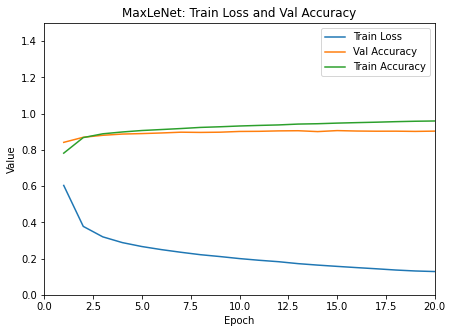

In [52]:
# Plot results
x = np.linspace(1, epochs, epochs)     
plt.figure(figsize=(7,5))
plt.title("MaxLeNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()


# 2a) Experimental LeNet - Window/Kernel Size


In [6]:
ExpLeNetWind = nn.Sequential(
    
            nn.Conv2d(1, 6, kernel_size=3, padding=2), nn.ReLU(),     
            nn.MaxPool2d(2),                                         
            nn.Conv2d(6, 16, kernel_size=3), nn.ReLU(),           
            nn.MaxPool2d(2),                                          
            nn.Flatten(),                                         
            nn.Linear(576, 120), nn.ReLU(),                          
            nn.Linear(120, 84), nn.ReLU(),                       
            nn.Linear(84, 10)                                       
)

In [7]:
summary(ExpLeNetWind, input_size = (1, 28, 28), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 30, 30]              60
              ReLU-2            [32, 6, 30, 30]               0
         MaxPool2d-3            [32, 6, 15, 15]               0
            Conv2d-4           [32, 16, 13, 13]             880
              ReLU-5           [32, 16, 13, 13]               0
         MaxPool2d-6             [32, 16, 6, 6]               0
           Flatten-7                  [32, 576]               0
            Linear-8                  [32, 120]          69,240
              ReLU-9                  [32, 120]               0
           Linear-10                   [32, 84]          10,164
             ReLU-11                   [32, 84]               0
           Linear-12                   [32, 10]             850
Total params: 81,194
Trainable params: 81,194
Non-trainable params: 0
---------------------------------

In [54]:
macs, params = get_model_complexity_info(ExpLeNetWind, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  81.19 k, 100.000% Params, 299.39 KMac, 100.000% MACs, 
  (0): Conv2d(60, 0.074% Params, 54.0 KMac, 18.037% MACs, 1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 5.4 KMac, 1.804% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 5.4 KMac, 1.804% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(880, 1.084% Params, 148.72 KMac, 49.675% MACs, 6, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 2.7 KMac, 0.903% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.7 KMac, 0.903% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(69.24 k, 85.277% Params, 69.24 KMac, 23.127% MACs, in_features=576, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.040% MACs, )
  (9): Linear(10.16 k, 12.518% Params, 10.16 KMac, 3.395% MACs, in_features=120, out_features=84, bias=True)
 

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ExpLeNetWind.parameters(), lr=0.001)

In [56]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ExpLeNetWind, criterion, optimizer)
    valLoop(validation_loader, ExpLeNetWind, criterion)

Epoch 1
loss: 2.2999041080474854
loss: 0.49144572019577026
Validation Accuracy: 84.3     Validation Loss:  0.43582490757821846
 
Epoch 2
loss: 0.2018158882856369
loss: 0.5049094557762146
Validation Accuracy: 86.52     Validation Loss:  0.36756171938329457
 
Epoch 3
loss: 0.2590183615684509
loss: 0.3975144326686859
Validation Accuracy: 87.82     Validation Loss:  0.3308207407212867
 
Epoch 4
loss: 0.36765968799591064
loss: 0.5799499154090881
Validation Accuracy: 88.03999999999999     Validation Loss:  0.3204267294452594
 
Epoch 5
loss: 0.12048450857400894
loss: 0.19006671011447906
Validation Accuracy: 89.07000000000001     Validation Loss:  0.30186004302324576
 
Epoch 6
loss: 0.2971160113811493
loss: 0.19480818510055542
Validation Accuracy: 89.89     Validation Loss:  0.28282983608234424
 
Epoch 7
loss: 0.20029640197753906
loss: 0.3354361355304718
Validation Accuracy: 88.71     Validation Loss:  0.2970353685581265
 
Epoch 8
loss: 0.16741430759429932
loss: 0.5053218603134155
Validation A

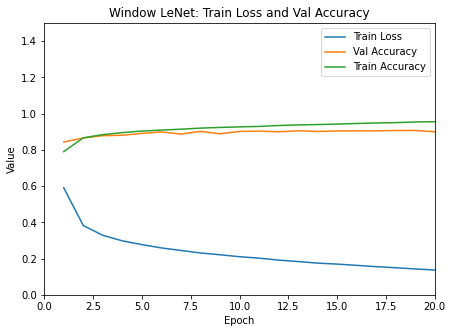

In [57]:
# Plot results  
x = np.linspace(1, epochs, epochs)      
plt.figure(figsize=(7,5))
plt.title("Window LeNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()


# 2b) Experimental LeNet - Output Channels

In [8]:
ExpLeNetChan = nn.Sequential(   
    
            nn.Conv2d(1, 32, kernel_size=5, padding=2), nn.ReLU(),    
            nn.MaxPool2d(2),                                          
            nn.Conv2d(32, 32, kernel_size=5), nn.ReLU(),              
            nn.MaxPool2d(2),                                         
            nn.Flatten(),                                           
            nn.Linear(800, 256), nn.ReLU(),                         
            nn.Linear(256, 64), nn.ReLU(),                           
            nn.Linear(64, 10)                                        
)

In [9]:
summary(ExpLeNetChan, input_size = (1, 28, 28), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 28, 28]             832
              ReLU-2           [32, 32, 28, 28]               0
         MaxPool2d-3           [32, 32, 14, 14]               0
            Conv2d-4           [32, 32, 10, 10]          25,632
              ReLU-5           [32, 32, 10, 10]               0
         MaxPool2d-6             [32, 32, 5, 5]               0
           Flatten-7                  [32, 800]               0
            Linear-8                  [32, 256]         205,056
              ReLU-9                  [32, 256]               0
           Linear-10                   [32, 64]          16,448
             ReLU-11                   [32, 64]               0
           Linear-12                   [32, 10]             650
Total params: 248,618
Trainable params: 248,618
Non-trainable params: 0
-------------------------------

In [59]:
macs, params = get_model_complexity_info(ExpLeNetChan, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  248.62 k, 100.000% Params, 3.49 MMac, 100.000% MACs, 
  (0): Conv2d(832, 0.335% Params, 652.29 KMac, 18.666% MACs, 1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 25.09 KMac, 0.718% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 25.09 KMac, 0.718% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(25.63 k, 10.310% Params, 2.56 MMac, 73.349% MACs, 32, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 3.2 KMac, 0.092% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 3.2 KMac, 0.092% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(205.06 k, 82.478% Params, 205.06 KMac, 5.868% MACs, in_features=800, out_features=256, bias=True)
  (8): ReLU(0, 0.000% Params, 256.0 Mac, 0.007% MACs, )
  (9): Linear(16.45 k, 6.616% Params, 16.45 KMac, 0.471% MACs, in_features=256, out_features=64, b

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ExpLeNetChan.parameters(), lr=0.001)

In [61]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ExpLeNetChan, criterion, optimizer)
    valLoop(validation_loader, ExpLeNetChan, criterion)

Epoch 1
loss: 2.3037941455841064
loss: 0.2766866385936737
Validation Accuracy: 87.1     Validation Loss:  0.3552575838475372
 
Epoch 2
loss: 0.32264092564582825
loss: 0.2951042354106903
Validation Accuracy: 89.33     Validation Loss:  0.2932131547516527
 
Epoch 3
loss: 0.272661030292511
loss: 0.189487487077713
Validation Accuracy: 89.88000000000001     Validation Loss:  0.2813172670551382
 
Epoch 4
loss: 0.13616299629211426
loss: 0.1832038164138794
Validation Accuracy: 90.78     Validation Loss:  0.2588734983231503
 
Epoch 5
loss: 0.14869895577430725
loss: 0.27908703684806824
Validation Accuracy: 90.85     Validation Loss:  0.2553373824317044
 
Epoch 6
loss: 0.1736561357975006
loss: 0.14403805136680603
Validation Accuracy: 91.45     Validation Loss:  0.24121077121875156
 
Epoch 7
loss: 0.07177985459566116
loss: 0.18499243259429932
Validation Accuracy: 91.2     Validation Loss:  0.25725723945865997
 
Epoch 8
loss: 0.14693999290466309
loss: 0.13855208456516266
Validation Accuracy: 90.86 

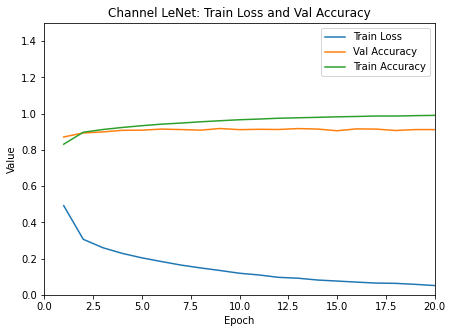

In [62]:
# Plot results
x = np.linspace(1, epochs, epochs)      
plt.figure(figsize=(7,5))
plt.title("Channel LeNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()


# 2c) Experimental LeNet - Conv Layers

In [10]:
ExpLeNetConv = nn.Sequential(
    
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),    
            nn.MaxPool2d(2),                                        
            nn.Conv2d(6, 16, kernel_size=5, padding=2), nn.ReLU(),  
            nn.MaxPool2d(2),                                          
            nn.Conv2d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),                                           
            nn.Linear(64, 32), nn.ReLU(),                            
            nn.Linear(32, 16), nn.ReLU(),                        
            nn.Linear(16, 10)                                       
)

In [11]:
summary(ExpLeNetConv, input_size = (1, 28, 28), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             156
              ReLU-2            [32, 6, 28, 28]               0
         MaxPool2d-3            [32, 6, 14, 14]               0
            Conv2d-4           [32, 16, 14, 14]           2,416
              ReLU-5           [32, 16, 14, 14]               0
         MaxPool2d-6             [32, 16, 7, 7]               0
            Conv2d-7             [32, 32, 7, 7]          12,832
              ReLU-8             [32, 32, 7, 7]               0
         MaxPool2d-9             [32, 32, 3, 3]               0
           Conv2d-10             [32, 64, 3, 3]          51,264
             ReLU-11             [32, 64, 3, 3]               0
        MaxPool2d-12             [32, 64, 1, 1]               0
          Flatten-13                   [32, 64]               0
           Linear-14                   

In [64]:
macs, params = get_model_complexity_info(ExpLeNetConv, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  69.45 k, 100.000% Params, 1.71 MMac, 100.000% MACs, 
  (0): Conv2d(156, 0.225% Params, 122.3 KMac, 7.157% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 4.7 KMac, 0.275% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 0.275% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 3.479% Params, 473.54 KMac, 27.712% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(0, 0.000% Params, 3.14 KMac, 0.184% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 3.14 KMac, 0.184% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(12.83 k, 18.478% Params, 628.77 KMac, 36.796% MACs, 16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU(0, 0.000% Params, 1.57 KMac, 0.092% MACs, )
  (8): MaxPool2d(0, 0.000% Params, 1.57 KMac, 0.092% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(51.26 k, 73.819% P

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ExpLeNetConv.parameters(), lr=0.001)

In [66]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ExpLeNetConv, criterion, optimizer)
    valLoop(validation_loader, ExpLeNetConv, criterion)

Epoch 1
loss: 2.3094310760498047
loss: 0.5004606246948242
Validation Accuracy: 80.82000000000001     Validation Loss:  0.5019731899372305
 
Epoch 2
loss: 0.4853556156158447
loss: 0.48286619782447815
Validation Accuracy: 84.75     Validation Loss:  0.4182478524387454
 
Epoch 3
loss: 0.3276069760322571
loss: 0.5626657605171204
Validation Accuracy: 86.98     Validation Loss:  0.3581047420993971
 
Epoch 4
loss: 0.4358469843864441
loss: 0.08447559177875519
Validation Accuracy: 87.91     Validation Loss:  0.33084468829174773
 
Epoch 5
loss: 0.3394554853439331
loss: 0.33838391304016113
Validation Accuracy: 88.3     Validation Loss:  0.32189080520226554
 
Epoch 6
loss: 0.38371047377586365
loss: 0.6309145092964172
Validation Accuracy: 88.94     Validation Loss:  0.3001691410169243
 
Epoch 7
loss: 0.12248941510915756
loss: 0.20557419955730438
Validation Accuracy: 89.07000000000001     Validation Loss:  0.3107216743567881
 
Epoch 8
loss: 0.13619229197502136
loss: 0.16387714445590973
Validation Ac

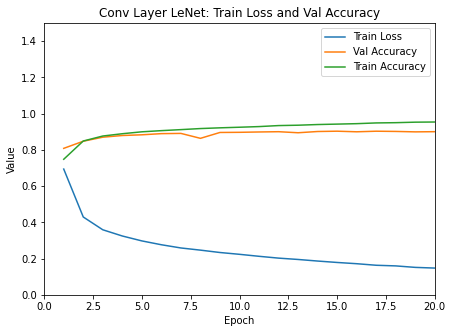

In [67]:
# Plot results   
x = np.linspace(1, epochs, epochs)      
plt.figure(figsize=(7,5))
plt.title("Conv Layer LeNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()


# 2d) Experimental LeNet - FC Layers

In [40]:
ExpLeNetFC = nn.Sequential(
    
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),    
            nn.MaxPool2d(2),                                          
            nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),            
            nn.MaxPool2d(2),                                          
            nn.Flatten(),                                            
            nn.Linear(400, 256), nn.ReLU(),                       
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),                       
            nn.Linear(32, 10)                                    

)

In [ ]:
summary(ExpLeNetFC, input_size = (1, 28, 28), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             156
              ReLU-2            [32, 6, 28, 28]               0
         MaxPool2d-3            [32, 6, 14, 14]               0
            Conv2d-4           [32, 16, 10, 10]           2,416
              ReLU-5           [32, 16, 10, 10]               0
         MaxPool2d-6             [32, 16, 5, 5]               0
           Flatten-7                  [32, 400]               0
            Linear-8                  [32, 256]         102,656
              ReLU-9                  [32, 256]               0
           Linear-10                  [32, 128]          32,896
             ReLU-11                  [32, 128]               0
           Linear-12                   [32, 64]           8,256
             ReLU-13                   [32, 64]               0
           Linear-14                   

In [41]:
macs, params = get_model_complexity_info(ExpLeNetFC, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  148.79 k, 100.000% Params, 523.21 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.105% Params, 122.3 KMac, 23.376% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 4.7 KMac, 0.899% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 0.899% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 1.624% Params, 241.6 KMac, 46.176% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.306% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.306% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(102.66 k, 68.994% Params, 102.66 KMac, 19.620% MACs, in_features=400, out_features=256, bias=True)
  (8): ReLU(0, 0.000% Params, 256.0 Mac, 0.049% MACs, )
  (9): Linear(32.9 k, 22.109% Params, 32.9 KMac, 6.287% MACs, in_features=256, out_features=128, bias=T

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ExpLeNetFC.parameters(), lr=0.001)

In [43]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ExpLeNetFC, criterion, optimizer)
    valLoop(validation_loader, ExpLeNetFC, criterion)

Epoch 1
loss: 2.290706157684326
loss: 0.307341068983078
Validation Accuracy: 82.17999999999999     Validation Loss:  0.48632207193884985
 
Epoch 2
loss: 0.4437580108642578
loss: 0.35284027457237244
Validation Accuracy: 86.22999999999999     Validation Loss:  0.38711444512247656
 
Epoch 3
loss: 0.37868165969848633
loss: 0.2912781834602356
Validation Accuracy: 85.41     Validation Loss:  0.397343154841909
 
Epoch 4
loss: 0.4657308757305145
loss: 0.3759935200214386
Validation Accuracy: 87.35000000000001     Validation Loss:  0.3495084028750563
 
Epoch 5
loss: 0.17693762481212616
loss: 0.2395053654909134
Validation Accuracy: 88.24     Validation Loss:  0.3206745018831457
 
Epoch 6
loss: 0.28645333647727966
loss: 0.15221655368804932
Validation Accuracy: 88.75     Validation Loss:  0.3223715439653054
 
Epoch 7
loss: 0.5499658584594727
loss: 0.26621702313423157
Validation Accuracy: 89.60000000000001     Validation Loss:  0.2914217749116615
 
Epoch 8
loss: 0.1569925844669342
loss: 0.2047788202

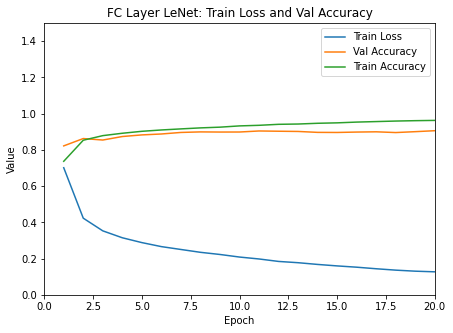

In [44]:
# Plot results   
x = np.linspace(1, epochs, epochs)      
plt.figure(figsize=(7,5))
plt.title("FC Layer LeNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()


# 2e) Experimental LeNet - Learning Rate

In [11]:
ExpLeNetLearn = nn.Sequential(

    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),     
    nn.MaxPool2d(2),                                          
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),          
    nn.MaxPool2d(2),                                          
    nn.Flatten(),
    nn.Linear(400, 120), nn.ReLU(),                         
    nn.Linear(120, 84), nn.ReLU(),                         
    nn.Linear(84, 10)                                      
)

In [12]:
summary(ExpLeNetLearn, input_size = (1, 28, 28), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             156
              ReLU-2            [32, 6, 28, 28]               0
         MaxPool2d-3            [32, 6, 14, 14]               0
            Conv2d-4           [32, 16, 10, 10]           2,416
              ReLU-5           [32, 16, 10, 10]               0
         MaxPool2d-6             [32, 16, 5, 5]               0
           Flatten-7                  [32, 400]               0
            Linear-8                  [32, 120]          48,120
              ReLU-9                  [32, 120]               0
           Linear-10                   [32, 84]          10,164
             ReLU-11                   [32, 84]               0
           Linear-12                   [32, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [13]:
macs, params = get_model_complexity_info(ExpLeNetLearn, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  61.71 k, 100.000% Params, 435.85 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.253% Params, 122.3 KMac, 28.061% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.079% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.079% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 3.915% Params, 241.6 KMac, 55.432% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.367% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.367% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(48.12 k, 77.983% Params, 48.12 KMac, 11.040% MACs, in_features=400, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.028% MACs, )
  (9): Linear(10.16 k, 16.472% Params, 10.16 KMac, 2.332% MACs, in_features=120, out_features=84, bias=Tru

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ExpLeNetLearn.parameters(), lr=0.0001)

In [15]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, ExpLeNetLearn, criterion, optimizer)
    valLoop(validation_loader, ExpLeNetLearn, criterion)

Epoch 1
loss: 2.3152363300323486
loss: 0.8267670273780823
Validation Accuracy: 73.92     Validation Loss:  0.6747302528197011
 
Epoch 2
loss: 0.9893612265586853
loss: 0.5346402525901794
Validation Accuracy: 77.42     Validation Loss:  0.5961042833023559
 
Epoch 3
loss: 0.6567239165306091
loss: 0.4096822142601013
Validation Accuracy: 79.24     Validation Loss:  0.5617961569811208
 
Epoch 4
loss: 0.3768235146999359
loss: 0.33396825194358826
Validation Accuracy: 81.08999999999999     Validation Loss:  0.518824759097145
 
Epoch 5
loss: 0.3884927034378052
loss: 0.5940000414848328
Validation Accuracy: 82.84     Validation Loss:  0.48288729810676634
 
Epoch 6
loss: 0.4623178243637085
loss: 0.2941366136074066
Validation Accuracy: 82.71     Validation Loss:  0.4729425026871526
 
Epoch 7
loss: 0.20184540748596191
loss: 0.2270846962928772
Validation Accuracy: 83.54     Validation Loss:  0.4511499640802606
 
Epoch 8
loss: 0.5141557455062866
loss: 0.2197611778974533
Validation Accuracy: 84.89999999

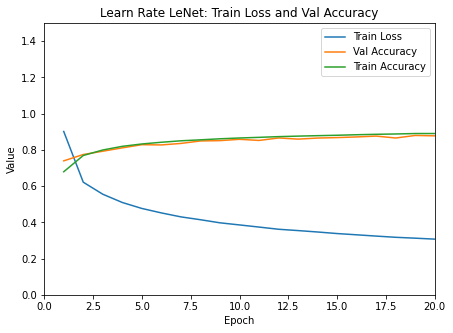

In [16]:
# Plot results   
x = np.linspace(1, epochs, epochs)      
plt.figure(figsize=(7,5))
plt.title("Learn Rate LeNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()


In [17]:
trainLosses, trainHist

([0.9013984229405722,
  0.6214531558195749,
  0.5549947891314825,
  0.5094297926028569,
  0.47651880617936454,
  0.451864084148407,
  0.4300498764872551,
  0.41432707730134327,
  0.3972409782886505,
  0.38560177760918934,
  0.3737924686113993,
  0.3616999568462372,
  0.3544420238931974,
  0.34659421243866284,
  0.3379843934893608,
  0.3310685098648071,
  0.3239920284807682,
  0.3173277738412221,
  0.31247236766616504,
  0.30721893773476283],
 [0.6790833333333334,
  0.76885,
  0.7992166666666667,
  0.81935,
  0.8323833333333334,
  0.8418666666666667,
  0.8499,
  0.8552333333333333,
  0.8609666666666667,
  0.8653833333333333,
  0.8689333333333333,
  0.8729,
  0.8757166666666667,
  0.8782,
  0.8804666666666666,
  0.8833833333333333,
  0.88575,
  0.8875333333333333,
  0.8900333333333333,
  0.8899833333333333])

# 3) Best Model w/ Dropout

In [12]:
DropLeNetChan = nn.Sequential(   
    
            nn.Conv2d(1, 32, kernel_size=5, padding=2), nn.ReLU(),    
            nn.MaxPool2d(2),                                         
            nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=5), nn.ReLU(),             
            nn.MaxPool2d(2),                                          
            nn.Dropout(0.3),
            nn.Flatten(),                                             
            nn.Linear(800, 256), nn.ReLU(),                           
            nn.Dropout(0.3),
            nn.Linear(256, 64), nn.ReLU(),                            
            nn.Dropout(0.3),
            nn.Linear(64, 10)                                        
)

In [13]:
summary(DropLeNetChan, input_size = (1, 28, 28), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 28, 28]             832
              ReLU-2           [32, 32, 28, 28]               0
         MaxPool2d-3           [32, 32, 14, 14]               0
           Dropout-4           [32, 32, 14, 14]               0
            Conv2d-5           [32, 32, 10, 10]          25,632
              ReLU-6           [32, 32, 10, 10]               0
         MaxPool2d-7             [32, 32, 5, 5]               0
           Dropout-8             [32, 32, 5, 5]               0
           Flatten-9                  [32, 800]               0
           Linear-10                  [32, 256]         205,056
             ReLU-11                  [32, 256]               0
          Dropout-12                  [32, 256]               0
           Linear-13                   [32, 64]          16,448
             ReLU-14                   

In [69]:
macs, params = get_model_complexity_info(DropLeNetChan, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  248.62 k, 100.000% Params, 3.49 MMac, 100.000% MACs, 
  (0): Conv2d(832, 0.335% Params, 652.29 KMac, 18.666% MACs, 1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 25.09 KMac, 0.718% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 25.09 KMac, 0.718% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.3, inplace=False)
  (4): Conv2d(25.63 k, 10.310% Params, 2.56 MMac, 73.349% MACs, 32, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU(0, 0.000% Params, 3.2 KMac, 0.092% MACs, )
  (6): MaxPool2d(0, 0.000% Params, 3.2 KMac, 0.092% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.3, inplace=False)
  (8): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (9): Linear(205.06 k, 82.478% Params, 205.06 KMac, 5.868% MACs, in_features=800, out_features=256, bias=True)


In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DropLeNetChan.parameters(), lr=0.001)

In [71]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, DropLeNetChan, criterion, optimizer)
    valLoop(validation_loader, DropLeNetChan, criterion)

Epoch 1
loss: 2.3087844848632812
loss: 0.3085750639438629
Validation Accuracy: 87.12     Validation Loss:  0.3551344999347251
 
Epoch 2
loss: 0.14488404989242554
loss: 0.22255806624889374
Validation Accuracy: 87.83     Validation Loss:  0.33459360478594663
 
Epoch 3
loss: 0.2839284837245941
loss: 0.16640044748783112
Validation Accuracy: 89.75     Validation Loss:  0.2802122470122366
 
Epoch 4
loss: 0.07673846930265427
loss: 0.2671598494052887
Validation Accuracy: 90.07     Validation Loss:  0.2679402864100739
 
Epoch 5
loss: 0.08118152618408203
loss: 0.23236508667469025
Validation Accuracy: 90.57     Validation Loss:  0.2593775345815923
 
Epoch 6
loss: 0.40632304549217224
loss: 0.17657463252544403
Validation Accuracy: 90.42999999999999     Validation Loss:  0.2714152595879266
 
Epoch 7
loss: 0.20439355075359344
loss: 0.19893263280391693
Validation Accuracy: 91.08000000000001     Validation Loss:  0.2783363019071591
 
Epoch 8
loss: 0.07800282537937164
loss: 0.09530064463615417
Validatio

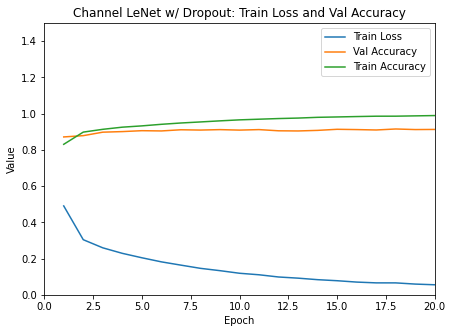

In [72]:
# Plot results   
x = np.linspace(1, epochs, epochs)      
plt.figure(figsize=(7,5))
plt.title("Channel LeNet w/ Dropout: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()


# 4) AlexNet

In [ ]:
# First analyze AlexNet's complexity
AlexNet = nn.Sequential(
    
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(6400, 4096), nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(4096, 10)

)


In [ ]:
summary(AlexNet, input_size = (1, 224, 224), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 96, 54, 54]          11,712
              ReLU-2           [32, 96, 54, 54]               0
         MaxPool2d-3           [32, 96, 26, 26]               0
            Conv2d-4          [32, 256, 26, 26]         614,656
              ReLU-5          [32, 256, 26, 26]               0
         MaxPool2d-6          [32, 256, 12, 12]               0
            Conv2d-7          [32, 384, 12, 12]         885,120
              ReLU-8          [32, 384, 12, 12]               0
            Conv2d-9          [32, 384, 12, 12]       1,327,488
             ReLU-10          [32, 384, 12, 12]               0
           Conv2d-11          [32, 256, 12, 12]         884,992
             ReLU-12          [32, 256, 12, 12]               0
        MaxPool2d-13            [32, 256, 5, 5]               0
          Flatten-14                 [3

In [ ]:
macs, params = get_model_complexity_info(AlexNet, (1, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  46.76 M, 100.000% Params, 939.85 MMac, 100.000% MACs, 
  (0): Conv2d(11.71 k, 0.025% Params, 34.15 MMac, 3.634% MACs, 1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU(0, 0.000% Params, 279.94 KMac, 0.030% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 279.94 KMac, 0.030% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(614.66 k, 1.314% Params, 415.51 MMac, 44.210% MACs, 96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(0, 0.000% Params, 173.06 KMac, 0.018% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 173.06 KMac, 0.018% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(885.12 k, 1.893% Params, 127.46 MMac, 13.561% MACs, 256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(0, 0.000% Params, 55.3 KMac, 0.006% MACs, )
  (8): Conv2d(1.33 M, 2.839% Params, 191.16 MMac, 20.339% MACs, 384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9):

# Simplified AlexNet

In [73]:
# Simplifying AlexNet
SimpAlexNet = nn.Sequential(
    
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 96, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(96, 64), nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(64, 32), nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(32, 10)

)

In [ ]:
summary(SimpAlexNet, input_size = (1, 28, 28), batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 14, 14]             320
              ReLU-2           [32, 32, 14, 14]               0
         MaxPool2d-3             [32, 32, 6, 6]               0
            Conv2d-4             [32, 64, 6, 6]          51,264
              ReLU-5             [32, 64, 6, 6]               0
         MaxPool2d-6             [32, 64, 2, 2]               0
            Conv2d-7            [32, 128, 2, 2]          73,856
              ReLU-8            [32, 128, 2, 2]               0
            Conv2d-9            [32, 128, 2, 2]         147,584
             ReLU-10            [32, 128, 2, 2]               0
           Conv2d-11             [32, 96, 2, 2]         110,688
             ReLU-12             [32, 96, 2, 2]               0
        MaxPool2d-13             [32, 96, 1, 1]               0
          Flatten-14                   

In [74]:
macs, params = get_model_complexity_info(SimpAlexNet, (1, 28, 28), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('Computational complexity: ', macs)
print('Number of parameters: ', params)

Sequential(
  392.33 k, 100.000% Params, 3.26 MMac, 100.000% MACs, 
  (0): Conv2d(320, 0.082% Params, 62.72 KMac, 1.921% MACs, 1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU(0, 0.000% Params, 6.27 KMac, 0.192% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.27 KMac, 0.192% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(51.26 k, 13.067% Params, 1.85 MMac, 56.534% MACs, 32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.071% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.071% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(73.86 k, 18.825% Params, 295.42 KMac, 9.050% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(0, 0.000% Params, 512.0 Mac, 0.016% MACs, )
  (8): Conv2d(147.58 k, 37.617% Params, 590.34 KMac, 18.084% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(0, 0.000% Par

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(SimpAlexNet.parameters(), lr=0.001)

In [76]:
# Begin training over 20 epochs
epochs = 20
valHist = []
valLosses = []
trainHist = []
trainLosses = []
interLosses = []
avgLosses = []

for t in range(epochs):
    actualEpoch = t+1
    print("Epoch", actualEpoch)
    trainLoop(training_loader, SimpAlexNet, criterion, optimizer)
    valLoop(validation_loader, SimpAlexNet, criterion)

Epoch 1
loss: 2.346029281616211
loss: 0.5338627099990845
Validation Accuracy: 82.87     Validation Loss:  0.46050899211591045
 
Epoch 2
loss: 0.20558832585811615
loss: 0.3028963804244995
Validation Accuracy: 85.95     Validation Loss:  0.38720899509688533
 
Epoch 3
loss: 0.578361988067627
loss: 0.392020583152771
Validation Accuracy: 87.31     Validation Loss:  0.3672756849648282
 
Epoch 4
loss: 0.3150469958782196
loss: 0.24454493820667267
Validation Accuracy: 87.79     Validation Loss:  0.3349049648585411
 
Epoch 5
loss: 0.5843637585639954
loss: 0.05830377712845802
Validation Accuracy: 88.73     Validation Loss:  0.31484613533075245
 
Epoch 6
loss: 0.22445973753929138
loss: 0.21710336208343506
Validation Accuracy: 88.63     Validation Loss:  0.31690434322427635
 
Epoch 7
loss: 0.04634065926074982
loss: 0.2774565517902374
Validation Accuracy: 88.47     Validation Loss:  0.32791926010776634
 
Epoch 8
loss: 0.09389222413301468
loss: 0.1891067624092102
Validation Accuracy: 88.82     Valida

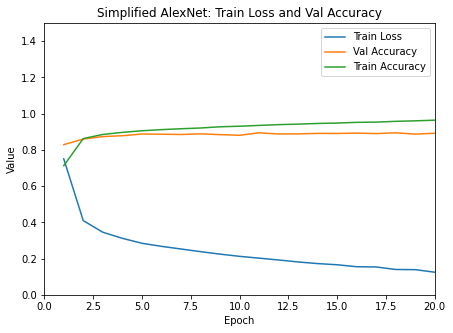

In [77]:
# Plot results    
x = np.linspace(1, epochs, epochs)  
plt.figure(figsize=(7,5))
plt.title("Simplified AlexNet: Train Loss and Val Accuracy")
plt.plot(x, trainLosses, label="Train Loss")
plt.plot(x, valHist, label="Val Accuracy")
plt.plot(x, trainHist, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.xlim(0, epochs)
plt.ylim(0, 1.5)
plt.show()
